In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Load in the Data
data = pd.read_csv("./data/spotify_millsongdata.csv")

# Split test set
data, data_test = train_test_split(data, test_size = .2)
data_train = data.copy(deep = True) #save unmodified training data for later

columns = ['artist', 'song', "text"]
data = data.loc[:, ['artist', 'song',"text"]]

# Turn text lower case and remove punctuation
data["text"] = data["text"].str.lower().str.replace('[^\w\s]','')
data_copy = data.copy(deep=True) # save a copy of the data in solid string form
data["text"] = data["text"].str.strip().str.split() #remove unnecessary spaces and turn into a list of words

# Preview the data before modifying it
print(data.shape)
data_copy.head()
data.head()



# order the artists by the number of songs they have in the data set
artists_counts = defaultdict(int)
for artist in list(data['artist']):
    artists_counts[artist] +=1
sorted_artist_counts = sorted(list(artists_counts.items()), key = lambda x: x[1], reverse = True)
sorted_artists = [x[0] for x in sorted_artist_counts]
top_artists = sorted_artists[:10]
print(top_artists)

---
# EXPLORING THE DATA
To explore the data, I processed it in different ways that would support my goal of predicting the artist based on the words in their song.
Initially, the data just has each artist, the song title, and the song lyrics for that entire song. In order to process the data, I used a Bag-of-words, technique, to make new features for the counts of each word in the song.  


In [91]:
# Word Visualization Helper Functions
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import operator
def get_word_counts(data, artist = None):
    """
    Gets the word counts for a given name in the data in a dictionary
    """
    if artist == None:
        artist_data = data
    else:
        artist_data = data[data_copy["artist"] == artist]
    word_counts = data.copy().text.str.split(expand=True).stack().value_counts().reset_index()
    word_counts.columns = ['Word', 'Count']
    
    return dict(zip(word_counts['Word'].tolist(), word_counts['Count'].tolist()))

def plot_artist_words(data, artist = None):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,7))
    word_dict = get_word_counts(data, artist)

    #plot the word bar plot
    top_word_counts = dict(sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)[:20])
    ax1.bar(top_word_counts.keys(), top_word_counts.values())
    ax1.set_title(artist)

    #plot the word cloud
    word_cloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 100).generate_from_frequencies(word_dict)
    ax2.imshow(word_cloud)
    ax2.set_title(artist)
    plt.show()

### 1. **Visualizing word frequencies across all songs in the data set**
To visualize word frequencies, I used two methods: a bar chart and a word cloud. The bar chart helps us easily see the most frequent words. This includes words like "the" and "i" which we would expect to be very frequent. The word cloud was just for fun, but it does give some visual intuition on the difference between different artists. 

### 2. **Visualizing word counts of all artists**
I added a feature in the data of the word count for each song. 
I then plotted a bar plot of artists to the average number of words in their songs. I thought this feature would be interesting as some artists (ex: rap artists) might have more words on average than others. It could also be interesting to visualize the number of unique words used by the artist.

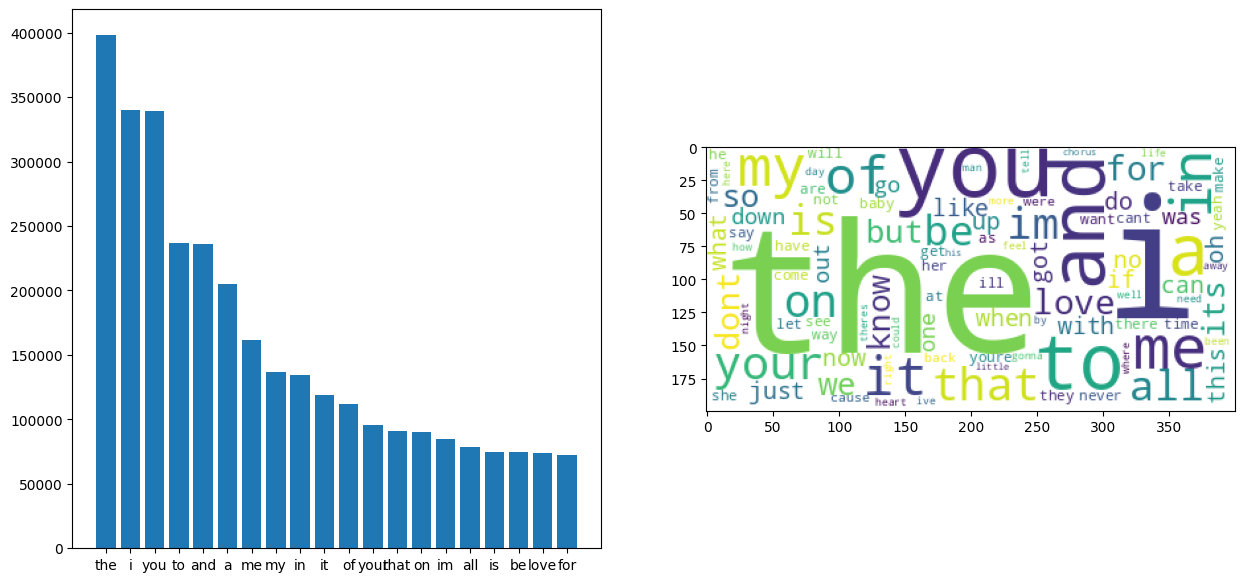

         artist                                           song_wcs  \
0       'n Sync  [211, 299, 208, 141, 278, 293, 445, 281, 113, ...   
1          ABBA  [99, 260, 208, 198, 256, 332, 293, 203, 279, 2...   
2   Ace Of Base  [286, 128, 460, 155, 195, 293, 144, 174, 241, ...   
3  Adam Sandler  [309, 204, 200, 129, 253, 252, 117, 228, 206, ...   
4         Adele  [156, 285, 204, 337, 335, 183, 215, 387, 363, ...   

   avg_song_wc  
0   264.611111  
1   259.943182  
2   244.629630  
3   269.396552  
4   296.365854  


/var/folders/tt/3pycs2310q194f1lhy4x0m840000gn/T/ipykernel_61681/3590224441.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_lengths_df["avg_song_wc"].iloc[[i]] = avg


<AxesSubplot:ylabel='Frequency'>

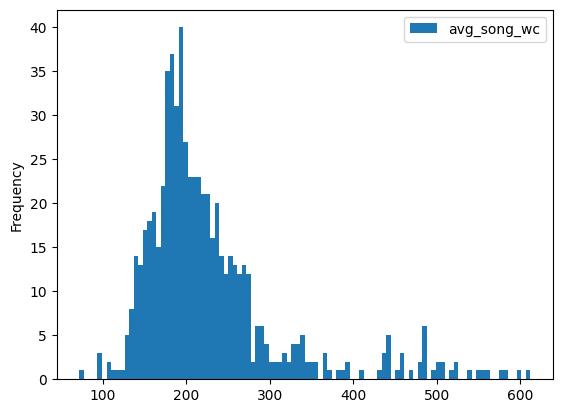

In [92]:
# 1. Visualizing word frequencies across all songs in the data set
plot_artist_words(data_copy)

# 2. Visualizing word counts of all artists
data["song_wc"] = [len(lyrics) for lyrics in data['text'].tolist()] # word counts

# group the word counts of each song by artist and average
song_lengths_df = data.copy().groupby("artist")["song_wc"].apply(list).reset_index(name = "song_wcs")

song_lengths_df["avg_song_wc"] = 0
for i in range(len(song_lengths_df["song_wcs"])):
    song_wcs = song_lengths_df["song_wcs"].iloc[[i]]
    song_wcs = song_wcs.tolist()[0]
    avg = sum(song_wcs)/ len(song_wcs)
    song_lengths_df["avg_song_wc"].iloc[[i]] = avg

song_lengths_df.plot.hist(column = "avg_song_wc", bins = 100)

### 3. **Narrowing the data in on a subset of artists**
-  ** Visualizing word frequencies for all the songs made by the selected artists**
-  ** Visualizing word frequencies for a single artist**
- For both of the above visualizations, I used the same methods as in (1).

In [93]:
# Modify the data for a selected subset of the artists
artists = ["Eminem", "Metallica", "Rihanna", "Taylor Swift"]

def subset_data(data_full, artists):
    """
    take a subset of the data that corresponds to the values in the list, classes
    """
    cols = data_full.columns
    array_data = data_full.to_numpy()

    # copy over data entries corresponding to the correct author
    subset_data = []
    for i in range(len(data_full)):
        artist = data_full['artist'].values[i]
        if artist in artists:
            subset_data.append(array_data[i])

    return pd.DataFrame(subset_data, columns = cols)

# Get the artist data set
data_artists = subset_data(data_copy, artists)
data_artists.head()


,artist,song,text
0,Metallica,Pumping Blood,pumping your blood \r\npumping blood \r\npum...
1,Eminem,Echo,chorus \r\noh all around the world \r\nthere...
2,Eminem,Crack A Bottle,ladies and gentlemen \r\nthe moment youve all...
3,Eminem,Elevator,all aboard okay next stop my basement haha \r...
4,Taylor Swift,Silent Night,silent night holy night \r\nall is calm and a...


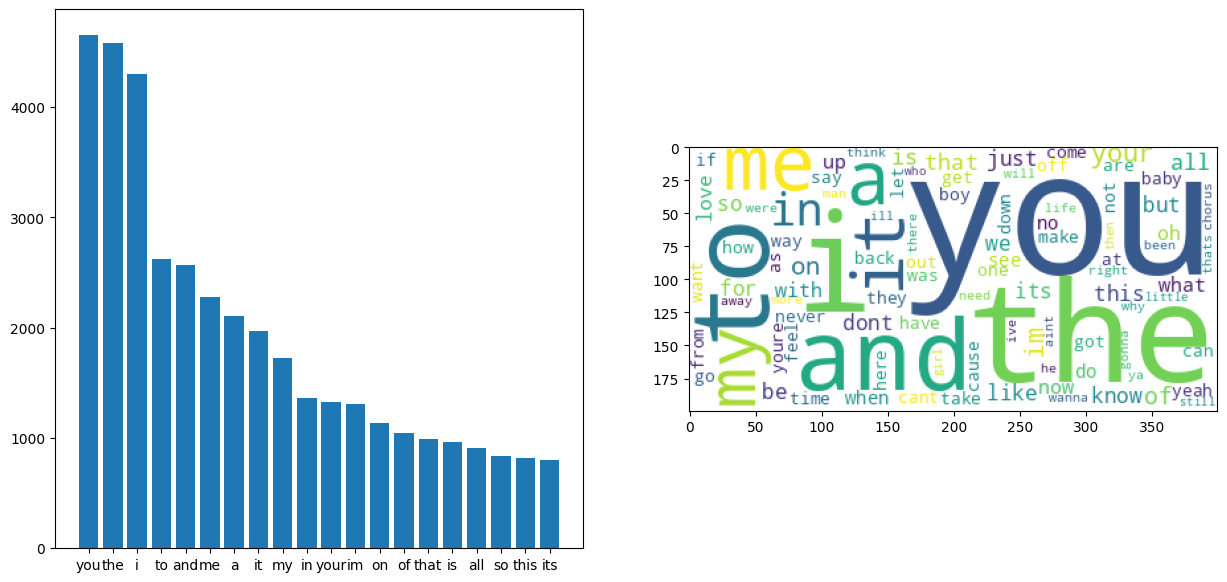

Eminem  : num songs =  56


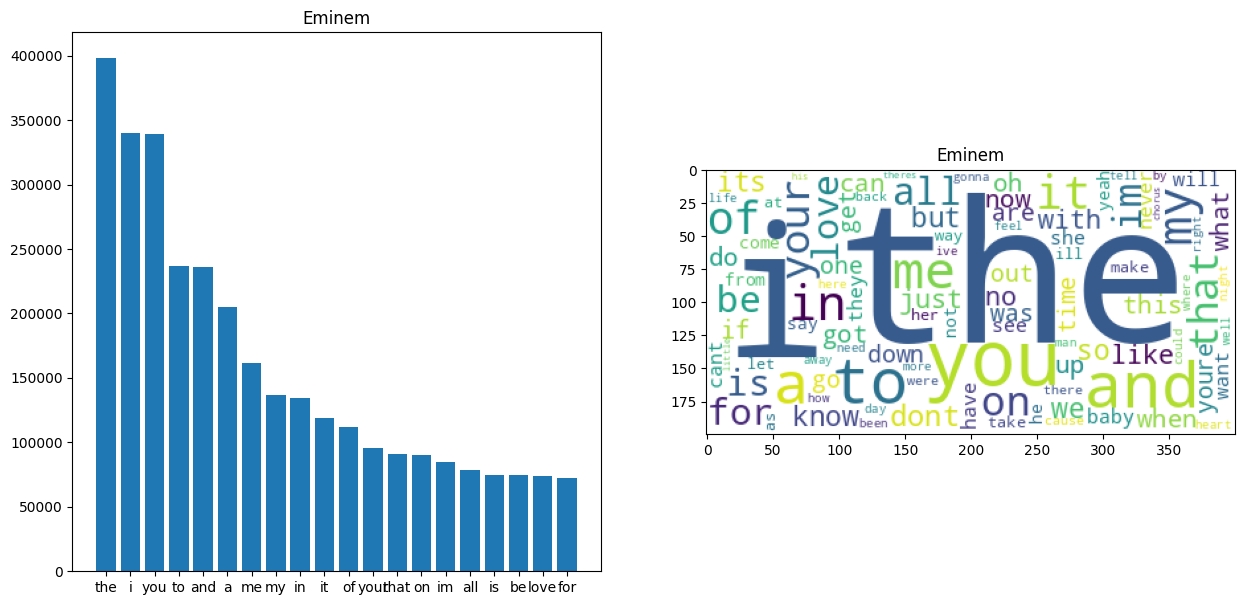

Metallica  : num songs =  125


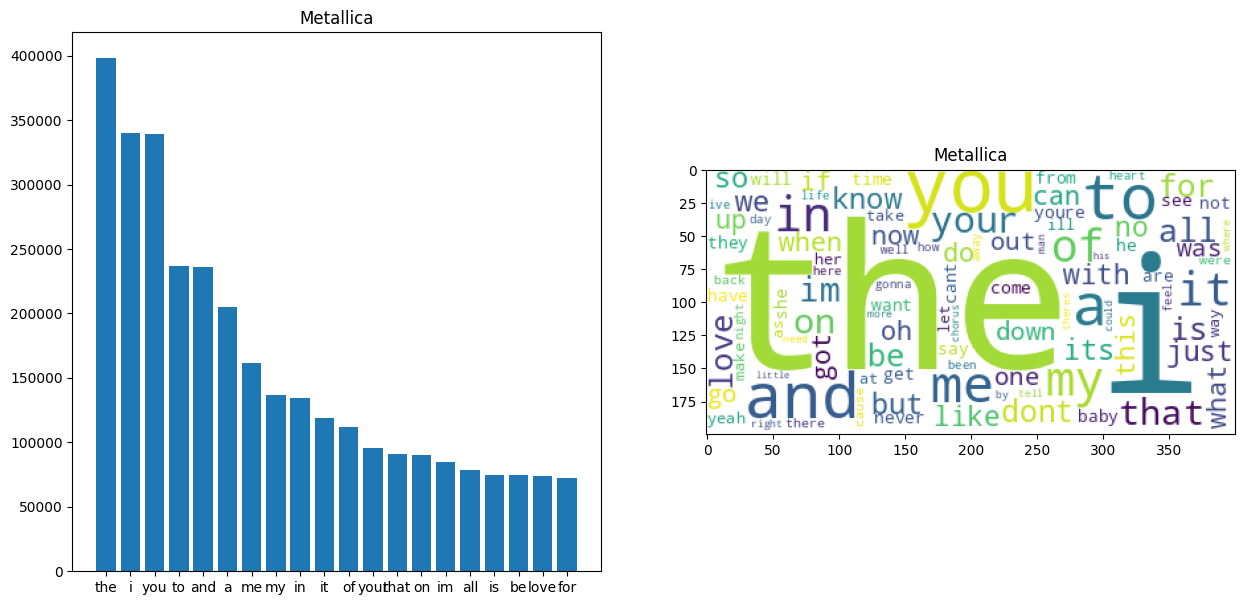

Rihanna  : num songs =  118


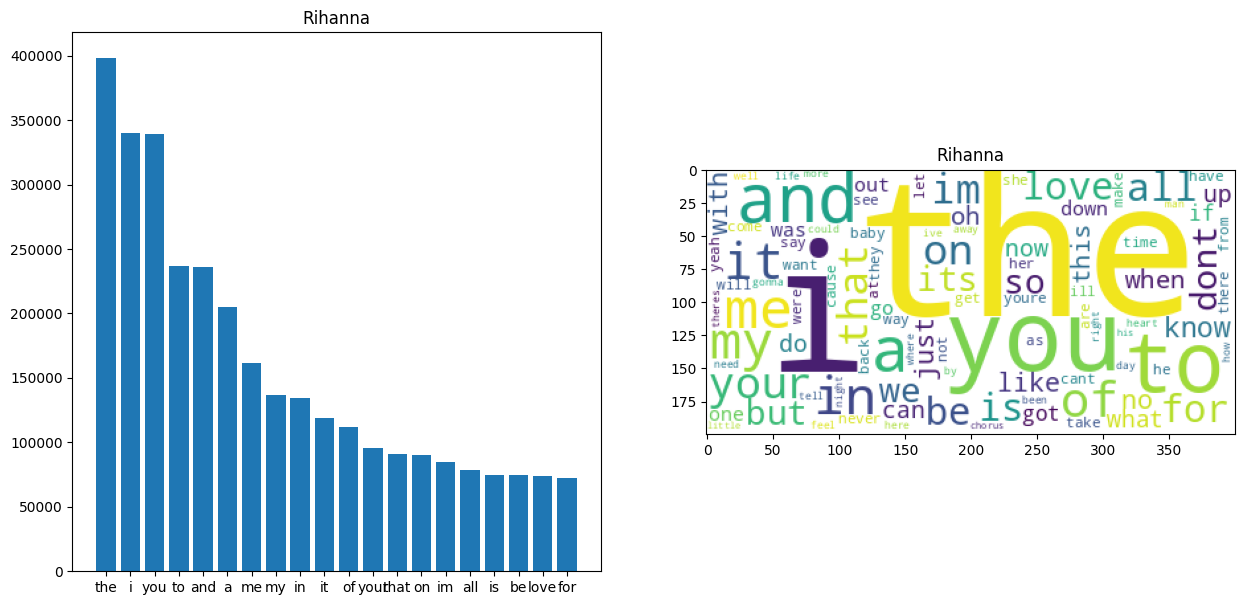

Taylor Swift  : num songs =  70


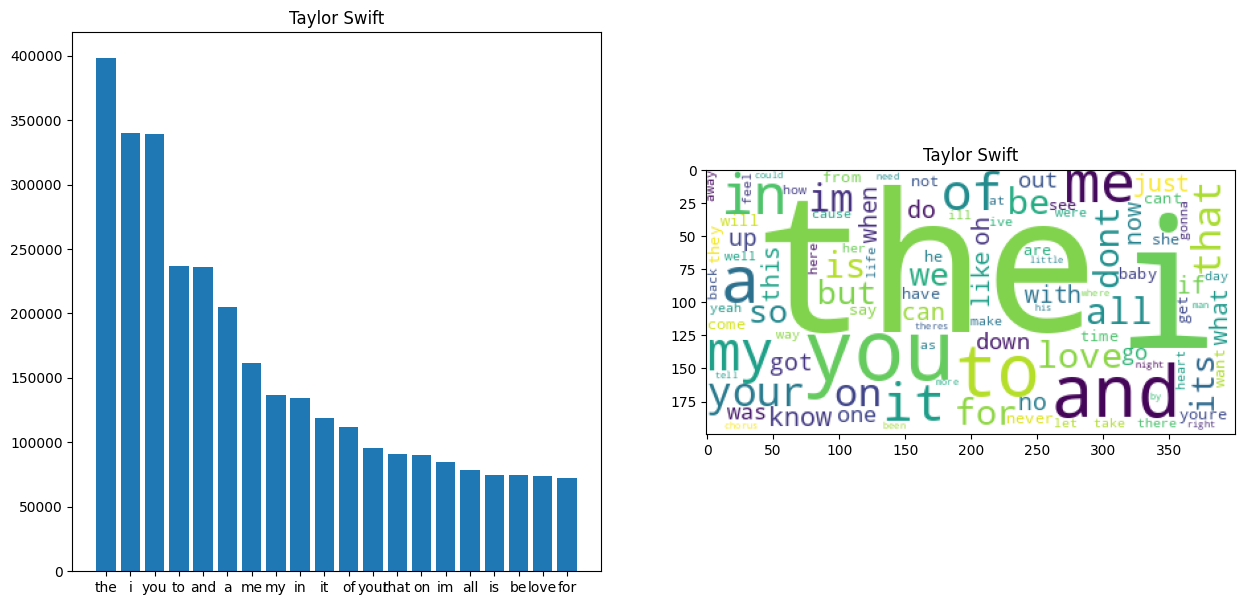

In [94]:
# 3. Artist specific visualizations
# Visualizing word frequencies for all the songs made by the selected artists
plot_artist_words(data_artists) 

# Visualizing word frequencies for a single artist (do for each selected artist)
for artist in artists:
    print(artist," : num songs = ", list(data["artist"]).count(artist))
    plot_artist_words(data_copy, artist)

### 4. **Determining what word counts to add as features**
- **If/When to standardize?** - one question I delt with was when to standardize the data. Because my data has text in a condensed form, I would first need to select a subset of words to add as features containing their word count (this is due to there being over 20,000 unique words in all songs) before standardizig. One idea I had was to just use the top 1,000 words across all the songs. However, one concern I had was whether this would just prioritize words that are in general common in English and not words that would help differentiate between artists since I couldn't standardize before selecting this initial set of features.
- I tested both standardizing and not standardizing, and since all of my data is word counts / collected the same, it makes the most to not standardize (this corresponds to my test results).
- **Initial features/word selection rationale:** Because my goal is to predict the artist given a particular song / lyrics of the song, I decided to just add all the words in the selected artists dataset and then standardize the data. 
- After standardizing each column, I'll later perform **dimension reduction** to reduce the overall size of the feature space of the data set. It makes sense to do dimension reduction as words are likely correlated (ex: words like "i" might be correlated with "you"), and also we have a very large p>>, so for computational reasons this is a good idea. 


In [95]:
# 4. Determining what word counts to add as features (this cell takes awhile to run)

# Get the unique words in the artist data in a dataframe corresponding to the word counts
word_count_data = data_artists.copy().text.str.split(expand=True).stack().value_counts().reset_index()
word_count_data.columns = ['Word', 'Count']
word_list  = word_count_data['Word'].tolist()

words = word_list[:100] # use the top 1000 words as features

# add the unique words as features
for word in words:
    data_artists[word] =  data_artists["text"].map(lambda x: x.count(word))

# divide the data into the response / features
X, y = data_artists.drop(['song', 'artist', 'text'], axis = 1), data_artists['artist']
X.head()


/var/folders/tt/3pycs2310q194f1lhy4x0m840000gn/T/ipykernel_61681/3122075334.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_artists[word] =  data_artists["text"].map(lambda x: x.count(word))


,you,the,i,to,and,me,a,it,my,in,...,aint,ya,man,thats,need,little,then,still,who,girl
0,20,43,133,2,8,17,138,17,8,47,...,0,1,3,0,0,4,0,0,0,0
1,11,63,171,17,14,14,151,14,16,40,...,2,0,6,0,3,0,0,0,1,4
2,13,59,165,7,16,17,166,32,9,32,...,2,0,4,0,0,0,1,0,2,0
3,18,41,173,33,10,22,226,27,10,53,...,1,3,1,2,0,0,2,0,1,0
4,0,6,40,0,3,0,38,1,0,6,...,0,0,0,0,0,0,0,0,0,0


### 5. **Visualizing the new feature distributions** (histogram of the Bag-Of-Words columns across all data) 
I also visualized the word distributions and the feature correlations to get more insight into the words themselves.

<AxesSubplot:ylabel='Frequency'>

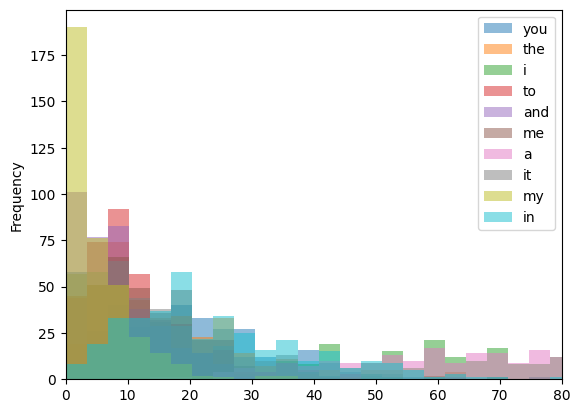

In [96]:
# 5. Visualize the features (test standardizing)
import seaborn as sns

# Plot the distributions of the top 100 words in a histogram
X.plot.hist(column = words[:10], bins=100, alpha=0.5, xlim =(0,80))

# # Standardize the data
# scalar = StandardScaler()
# X = pd.DataFrame(scalar.fit_transform(X), columns = X.columns)
# X.plot.hist(column = words[:10], bins=100, alpha=0.5, xlim =(0,5))


<AxesSubplot:>

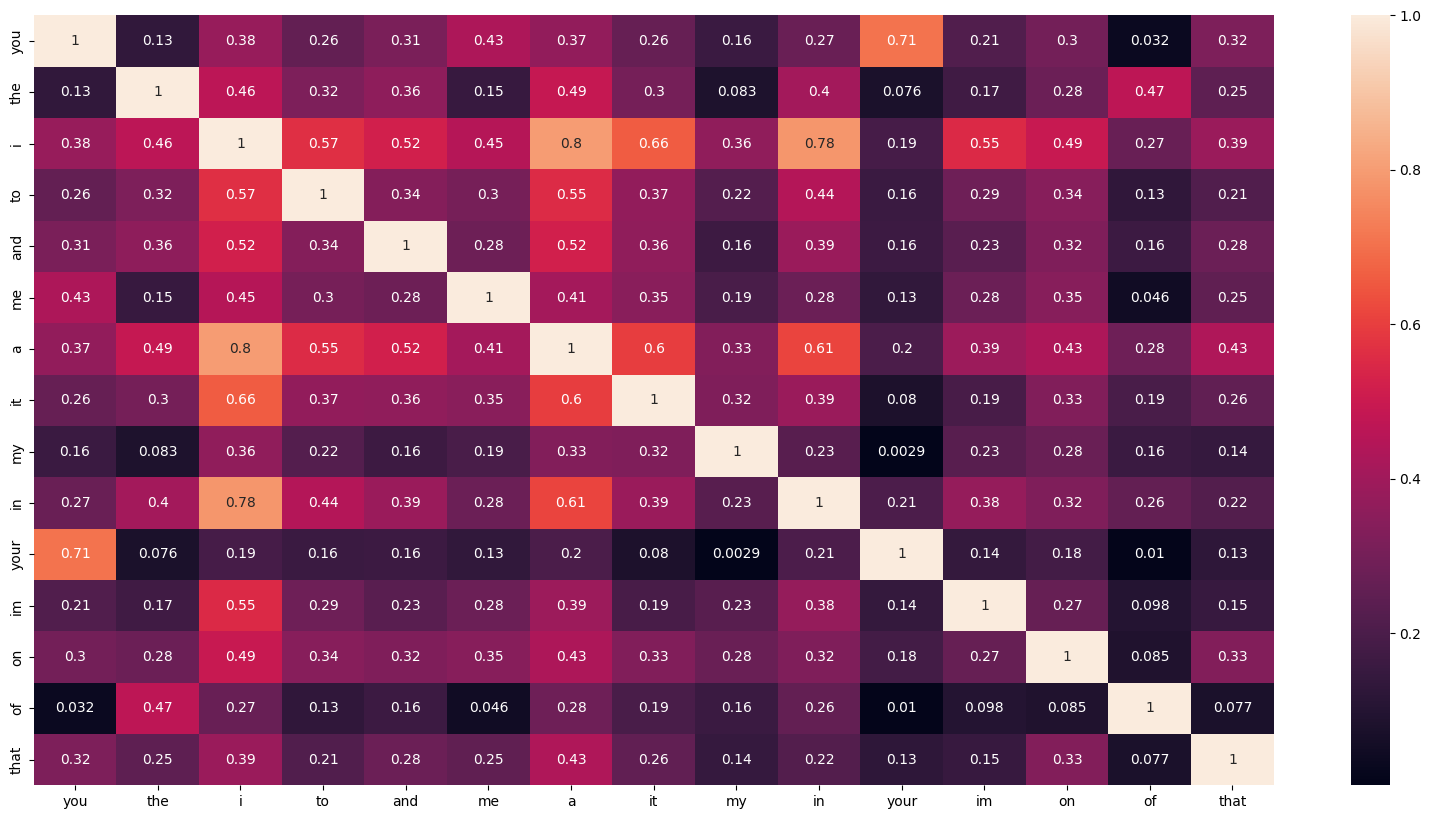

In [97]:
# Plot the pairwise correlation of features
plt.figure(figsize=(20, 10))
X_smol = X[words[:15]].copy()
sns.heatmap(X_smol.corr().abs(), annot=True)


---
# UNSUPERVISED TECHNIQUES
Here, I visualize the data using PCA (later I also explore some clustering models)

#### **Motivation**: 
Because we have high dimensional data, I wanted to perform some dimension reduction for computational purposes. Additionally, I thought it would be interesting to see which words the models chose to be important for determining the clusters of artists (i.e, **interpretibility**).  Another reason why I chose to reduce the dimension of the data, is to **denoise** and deal with **correlated words**.

#### **Analysis**: 
As shown below, we see that for features like "it" and "a" which have a high correlation value of 0.8, PCA chose to primarily use "a" while giving "it" a lower weight which deals with the correlation. Also, we see that some words such as "the", "and", "to" have lower importances despite them occuring frequently in the data.


In [98]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# ---------------- Helper Functions----------------

def get_color_array(labels, y):
    """ 
    Get a color array corresponding a color to each label
    """
    label_colors = {}
    cmap = plt.get_cmap('Spectral')
    colormap = cmap(np.linspace(0, 1, len(labels))) #colors for each label
    for i, label in enumerate(labels):
        label_colors[label] = colormap[i]
    color_array = [label_colors[label] for label in y]
    return color_array, label_colors

# ---------------- More Data Processing ----------------

# 2. Map artists to colors for plotting purposes
color_array, artist_colors = get_color_array(artists, y)

# ---------------- PCA Helper Functions----------------
def viz_2Dembedding(X_embedded, model_name):
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color_array)
    custom_points = [Line2D([0], [0] , color = artist_colors[artist] , lw = 4) for artist in artists]
    plt.legend(custom_points, artists)
    
    plt.xlabel("component 0")
    plt.ylabel("component 1")
    plt.title("Artist Words")

    plt.title(model_name + " Visualization")
    plt.show()
    plt.clf()

def viz_feature_weights(features, feature_weights, model_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
    ax1.bar(features, feature_weights[0][:len(features)])
    ax1.set_title("feature 1 weights")
    ax1.set_ylabel("feature weights")
    ax1.set_xlabel("words")

    ax2.bar(features, feature_weights[1][:len(features)])
    ax2.set_title("feature 2 weights")
    ax2.set_ylabel("feature weights")
    ax2.set_xlabel("words")
    plt.suptitle(model_name + " Features")
    plt.show()
    plt.clf()


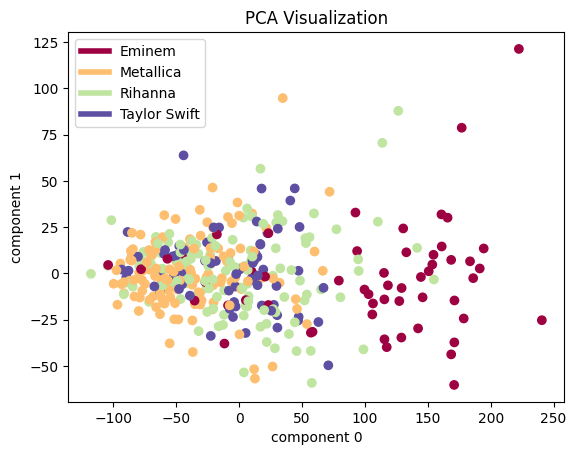

<Figure size 640x480 with 0 Axes>

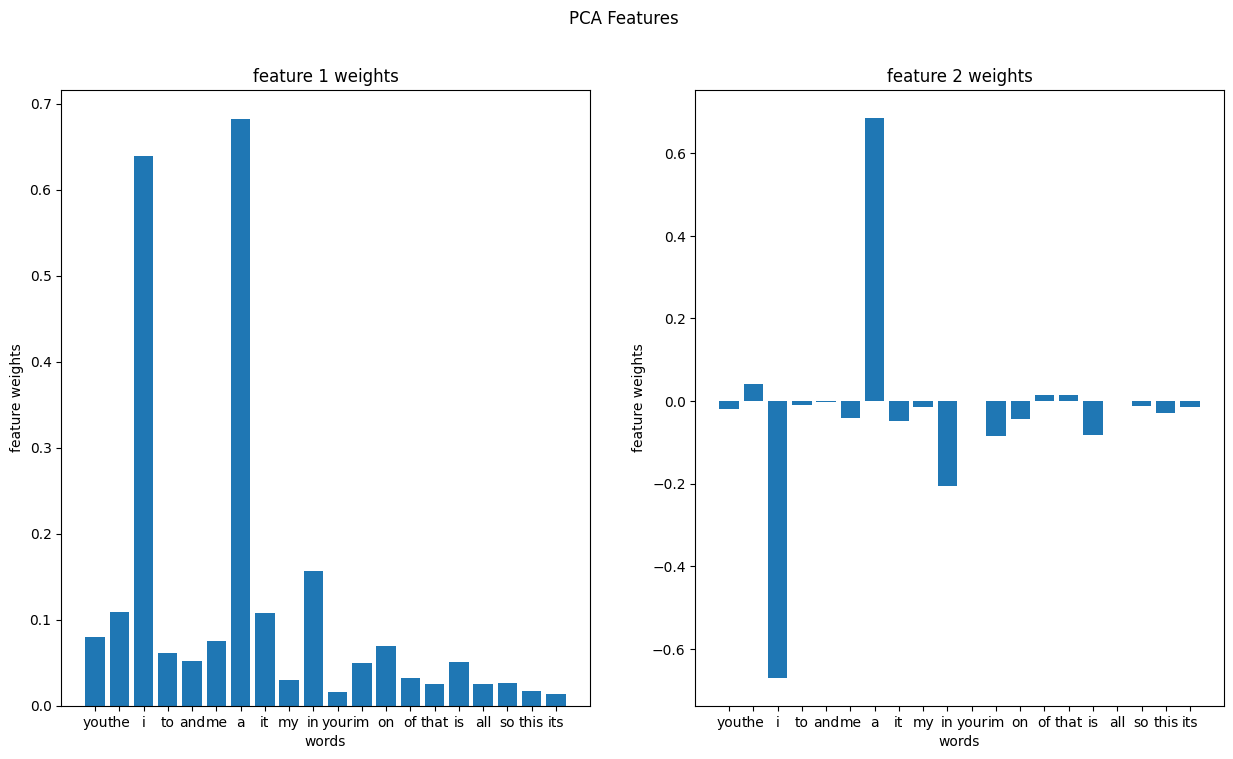

<Figure size 640x480 with 0 Axes>

In [99]:
# UNSUPERVISED LEARNING / EXPLORING THE DATA
words_to_viz = words[:20]

# PCA Embedding
model = PCA(n_components = 2)
X_embedded = model.fit_transform(X)
viz_2Dembedding(X_embedded, "PCA")
viz_feature_weights(words_to_viz, model.components_, "PCA")


---
# MODEL TRAINING

In [100]:
# class summarizing the processing determined in the previous sections
from sklearn.preprocessing import StandardScaler
class Processor():
    def __init__(self):
        #the artists considered in this dataset
        self.artists = []

        # the words / features
        self.words = []

        # the scalar for the dataframe
        self.scalar = StandardScaler()
        self.scale_data = True


    def fit_process(self, data, artists, num_features = 100, scale_data = True):
        self.artists = artists
        self.scale_data = scale_data

        data = data.loc[:, ['artist', 'song',"text"]]

        # Turn text lower case and remove punctuation
        data["text"] = data["text"].str.lower().str.replace('[^\w\s]','')
        data_copy = data.copy(deep=True) # save a copy of the data in solid string form
        data["text"] = data["text"].str.strip().str.split() #remove unnecessary spaces and turn into a list of words

        # Get the artist data set
        data_artists = self.subset_data(data_copy, artists)

        # Get the unique words in the artist data in a dataframe corresponding to the word counts
        word_count_data = data_artists.copy().text.str.split(expand=True).stack().value_counts().reset_index()
        word_count_data.columns = ['Word', 'Count']
        self.words =  word_count_data['Word'].tolist()[:num_features] # use the top num_features words as features

        # Add the unique words as features
        for word in self.words:
            data_artists[word] =  data_artists["text"].map(lambda x: x.count(word))
        
        X, y = data_artists.drop(['song', 'artist', 'text'], axis = 1), data_artists['artist']
        
        # Scale the data (and fit the scalar)
        if scale_data:
            X = pd.DataFrame(self.scalar.fit_transform(X), columns = X.columns)

        return X, y
    
    def process(self, data): #assumes that fit_process has been called
        data = data.loc[:, ['artist', 'song',"text"]]

        # Turn text lower case and remove punctuation
        data["text"] = data["text"].str.lower().str.replace('[^\w\s]','')
        data_copy = data.copy(deep=True) # save a copy of the data in solid string form
        data["text"] = data["text"].str.strip().str.split() #remove unnecessary spaces and turn into a list of words

        # Get the artist data set (using the existing list of artists)
        data_artists = self.subset_data(data_copy, self.artists)

        # Add the same features
        for word in self.words:
            data_artists[word] =  data_artists["text"].map(lambda x: x.count(word))

        X, y = data_artists.drop(['song', 'artist', 'text'], axis = 1), data_artists['artist']

        # Scale the data (and fit the scalar)
        if self.scale_data:
            X = pd.DataFrame(self.scalar.fit_transform(X), columns = X.columns)
        return X, y
    
    def subset_data(self, data_full, artists):
        """
        take a subset of the data that corresponds to the values in the list, classes
        """
        cols = data_full.columns
        array_data = data_full.to_numpy()

        # copy over data entries corresponding to the correct author
        subset_data = []
        for i in range(len(data_full)):
            artist = data_full['artist'].values[i]
            if artist in artists:
                subset_data.append(array_data[i])

        return pd.DataFrame(subset_data, columns = cols)

In [ ]:
# Process the data
artists = ["Eminem", "Metallica", "Rihanna", "Taylor Swift"]

processor = Processor()
X_train, y_train = processor.fit_process(data_train, artists = artists, num_features = 100, scale_data = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)
X_test, y_test = processor.process(data_test)


# Preview the processed Data
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

---
## 1. Clustering (Unsupervised)

#### **Motivation:** 
Since we are trying to classify songs by their artists, it makes sense to look at clustering algorithms to see not only how close/clustered certain artists are based on the songs of the words but to also compare similarity between artists (this could also be interesting to see if artists of similar genres appear near eachother). I the primary purpose of this is to get more insight into the structure/patterns of the data.

#### **Expectations:**
I expect that k-means won't work very well because we are working with count data and not eulclidean distance. K-means works best for spherical Gaussian clusters that are balanced which probably won't apply. We also have a lot of features, so to evaluate this model, I plan on first doing PCA, then k-means (k-means performs poorly on p>>n). Spectral clustering works well on imbalanced/non-compact clusters. 


In [102]:
# Helper functions
from sklearn.decomposition import PCA

def pca_vizualization(X, y, labels, title):
    """
    X - an nxp matrix
    y - the actual clusters
    labels - the cluster labels of each row/entry in X
    title - the title for the plot

    1. Performs dimension reduction on X -> nx2 matrix
    2. Plots X with the cluster labels as coloring

    """
    NUM_CLUSTERS = len(artists)
    # embed the data in 2 dimensions for plotting purposes
    X_embedded = PCA(n_components = 2).fit_transform(X)

    #get colors corresponding to the labels
    cmap = (plt.get_cmap('Spectral'))(np.linspace(0, 1, NUM_CLUSTERS))
    label_colors = [cmap[i] for i in labels]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 8))

    # ---------- plot the inputted cluster labels -------------
    ax1.scatter(X_embedded[:,0], X_embedded[:,1], c = label_colors)
    ax1.set_xlabel("component 0")
    ax1.set_ylabel("component 1")
    ax1.set_title(title)
    

    # ---------- plot the correct cluster labels -------------
    authors= list(set(y))   # a list of all the authors included in the data set
    label_colors = [cmap[authors.index(author)] for author in y]
    ax2.scatter(X_embedded[:,0], X_embedded[:,1], c = label_colors)
    ax2.set_xlabel("component 0")
    ax2.set_ylabel("component 1")
    ax2.set_title("Correct Clusters")
    
    plt.show()
    plt.clf()

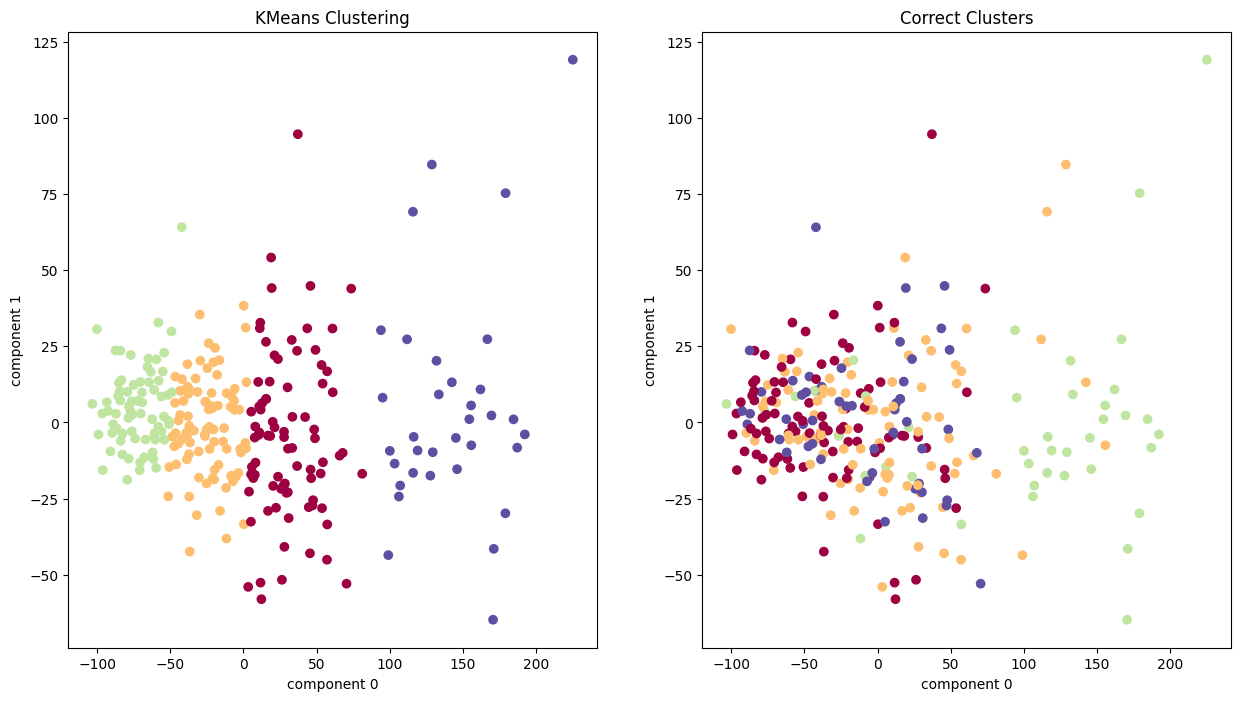

<Figure size 640x480 with 0 Axes>

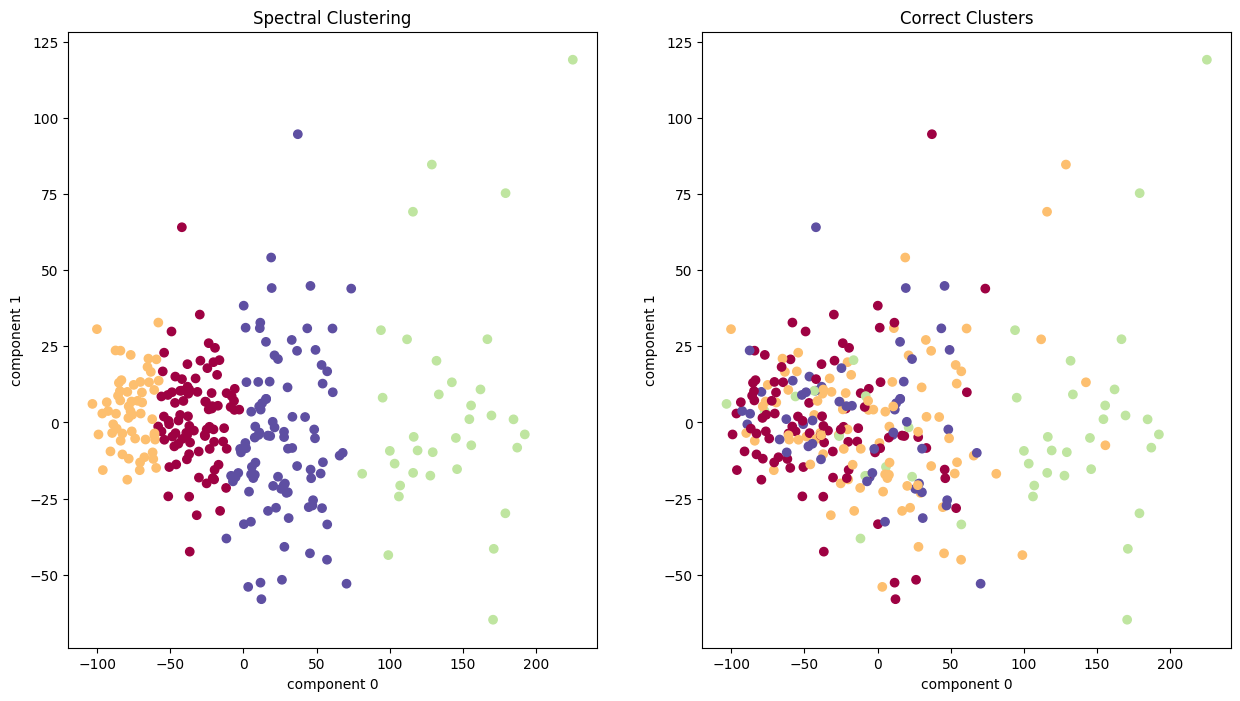

<Figure size 640x480 with 0 Axes>

In [103]:
# 1. Clustering Model
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score

num_clusters = len(artists)
# First perform PCA to reduce the dimension of the data
X_embedded =  PCA(n_components = 2).fit_transform(X_train)

#k-means clustering (not linearly separable so doesn't work well)
kmeans = KMeans(n_clusters = num_clusters).fit(X_train)
pca_vizualization(X_train, y_train, kmeans.labels_, "KMeans Clustering")

#spectral clustering
spectral = SpectralClustering(n_clusters = num_clusters, assign_labels='discretize',  affinity="nearest_neighbors")
spectral_labels = spectral.fit_predict(X_embedded)
pca_vizualization(X_train, y_train, spectral_labels, "Spectral Clustering")

---
## 2. Decision Trees and Random Forrests

In [104]:
# Helper functions
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

# Plot parameter tuning curves to see how test/ train is affected by different hyper parameter values
def plot_error_curves(parameters, param_name, base_estimator, model_name, log_scale = False):
    train_score, test_score = validation_curve(base_estimator, X_train, y_train,
                                       param_name = param_name,
                                       param_range = parameters,
                                        cv = 3, scoring = "accuracy")
    
    mean_train_score = [1-val for val in np.mean(train_score, axis = 1)]
    mean_test_score = [1-val for val in np.mean(test_score, axis = 1)]

    # Plot testing/ training scores
    fig = plt.figure()
    plt.plot(parameters, mean_train_score, label = "Training Score", color = 'b')
    plt.plot(parameters, mean_test_score, label = "Validation Score", color = 'g')

    # Label the plot
    plt.xlabel(param_name)
    plt.ylabel("error")
    if log_scale == True:
        plt.xscale("log")
    plt.title(model_name + " : " +param_name + " vs. error")
    plt.legend()
    plt.show()

def parameter_tuning(model_name, param_grid, base_estimator):
    tuner = RandomizedSearchCV(estimator = base_estimator, param_distributions = param_grid, refit = True)
    tuner.fit(X_train ,y_train)
    print("\n• "+model_name+str(tuner.best_params_))

    tuned_model = tuner.best_estimator_
    print("train score: ", tuned_model.score(X_train, y_train), "\ntest score:", tuned_model.score(X_test,y_test))
    return tuned_model

def OOB_parameter_tuning(rf, max_depths, max_features): # performs OOB param tuning for random forests
    best_error, best_depth, best_max_features = 1 , 1, 1

    #perform a grid search and use the oob error as validation error
    for max_depth in max_depths:
        for max_feature in max_features:
            rf.set_params(max_depth = max_depth, max_features = max_feature)
            rf.fit(X_train, y_train)
            oob_error = 1 - rf.oob_score_

            if oob_error < best_error:
                best_error = oob_error
                best_max_features = max_feature
                best_depth = max_depth
    
    #fit the model
    rf.set_params(max_depth = best_depth, max_features = best_max_features)
    rf.fit(X_train, y_train)   

    #print the results
    print("\n• RandomForests (max_features = " + str(best_max_features) +", max_depth = " + str(best_depth))
    print("\ntraining error = ", rf.score(X_train, y_train), "\ntesting error = ", rf.score(X_test, y_test))
    return rf

def print_ordered_features(feature_importances, features_names):
    print("\n---- top 20 features (in order of imortance) ----")
    zipped_features = list(zip(feature_importances, features_names))
    zipped_features.sort(key = lambda x:x[0], reverse=True)

    ordered_features = [item[1] for item in zipped_features[:20]]
    print(ordered_features)



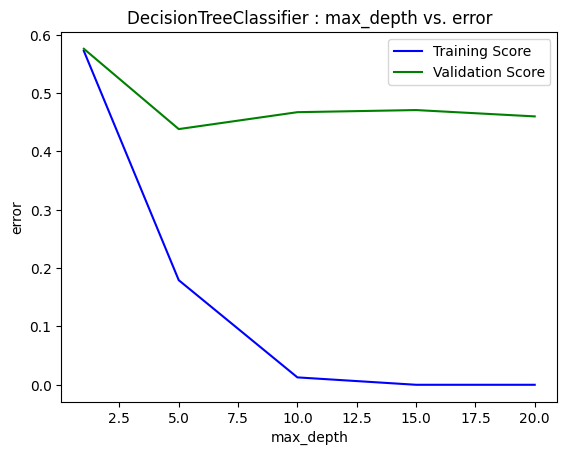

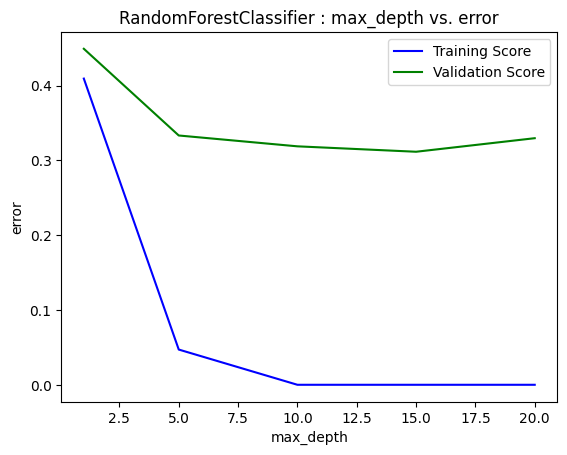

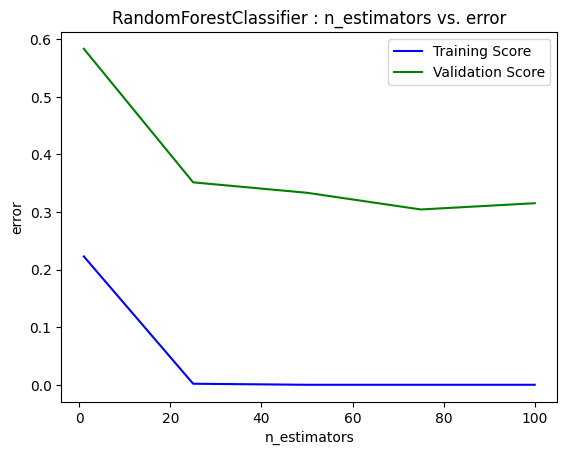

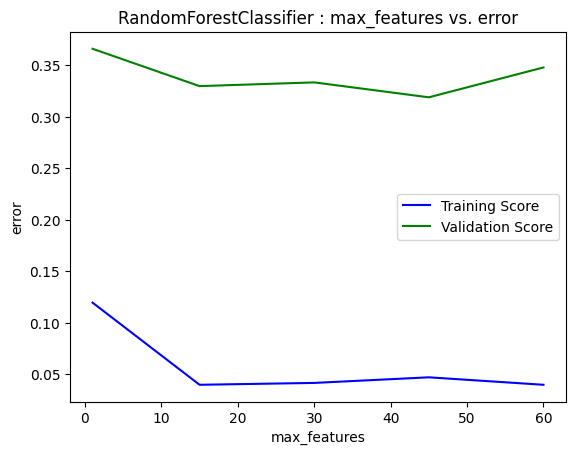

In [105]:
# 2. Random Forests Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Get insight into how different hyper parameters affect the validation errors to determine a tuning range

# Decision Trees Hyperparameters
plot_error_curves(parameters = [int(val) for val in np.linspace(1, 20, 5)], 
                  param_name = 'max_depth',
                  base_estimator = DecisionTreeClassifier(),
                   model_name = "DecisionTreeClassifier")

# Random Forests Hyperparameters
plot_error_curves(parameters = [int(val) for val in np.linspace(1, 20, 5)], 
                  param_name = 'max_depth',
                  base_estimator = RandomForestClassifier(),
                  model_name = "RandomForestClassifier")
plot_error_curves(parameters = [int(val) for val in np.linspace(1, 100, 5)], 
                  param_name = 'n_estimators',
                  base_estimator = RandomForestClassifier(),
                  model_name = "RandomForestClassifier")
plot_error_curves(parameters = [int(val) for val in np.linspace(1, 60, 5)], 
                  param_name = 'max_features',
                  base_estimator = RandomForestClassifier(max_depth = 5),
                model_name = "RandomForestClassifier")
                  

### Parameter Tuning for Trees and Random Forests:
By analyzing these hyper parameter validation plots, we can get a good sense of where the validation error starts to increase (indicating overfitting). From this, we can better select a range to tune the parameters in.
* **Decision Trees**:
    * **max_depth**: range to tune [1,9]
* **Random Forests**:
    * **max_depth**: range to tune [1,9]
    * **n_estimators**: range to tune [40, 80] ** for computational reasons, I decided to just use the plot to fix this value to be 80
    * **max_depth**: range to tune [5, 30]


• DecisionTreeClassifier{'max_depth': 2}
train score:  0.5833333333333334 
test score: 0.5125

---- top 20 features (in order of imortance) ----
['i', 'baby', 'from', 'you', 'the', 'to', 'and', 'me', 'a', 'it', 'my', 'in', 'your', 'im', 'on', 'of', 'that', 'is', 'all', 'so']


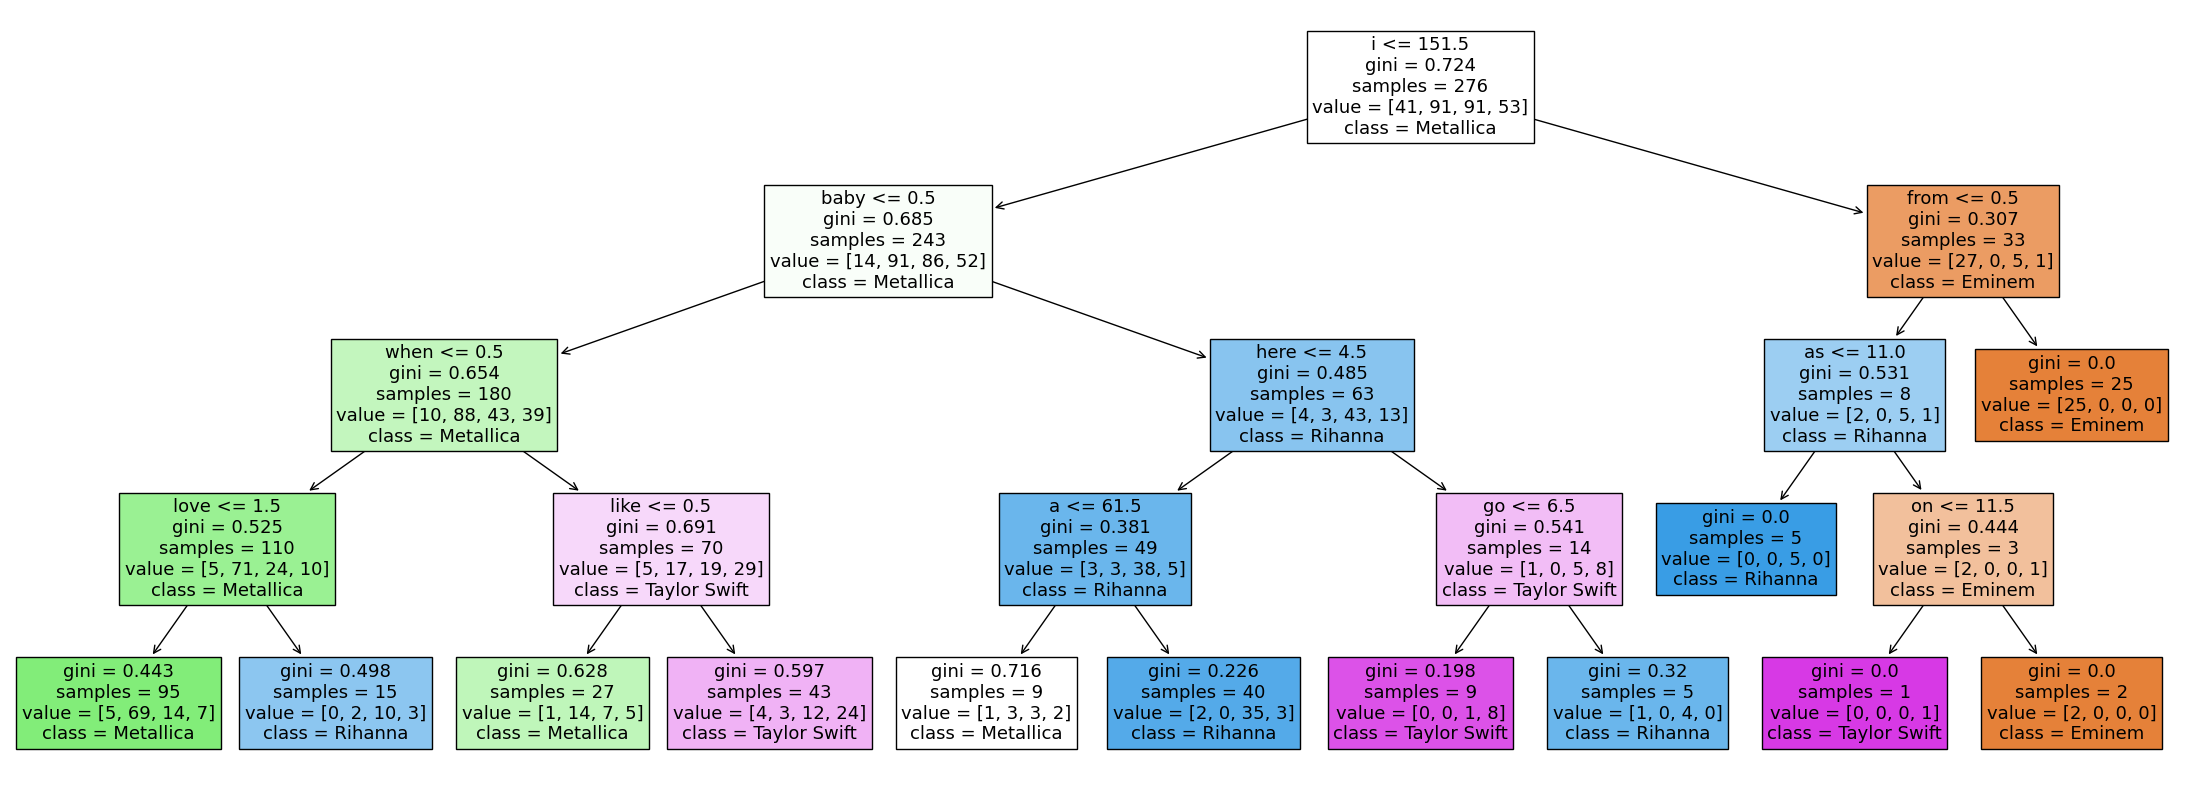


• RandomForests (max_features = 15, max_depth = 7

training error =  0.9818840579710145 
testing error =  0.6875

---- top 20 features (in order of imortance) ----
['i', 'baby', 'from', 'you', 'the', 'to', 'and', 'me', 'a', 'it', 'my', 'in', 'your', 'im', 'on', 'of', 'that', 'is', 'all', 'so']


In [106]:
# Tune the hyper parameters of each model using the ranges determined above
from sklearn.tree import plot_tree

# -------------------- Decision Tree Tuning and Evaluation --------------------
param_grid = {"max_depth": (np.rint(np.linspace(1,9, 10))).astype(int)} 
decision_tree = parameter_tuning("DecisionTreeClassifier", param_grid, DecisionTreeClassifier())
print_ordered_features(decision_tree.feature_importances_, X_train.columns)


# Plot the decision tree
fig = plt.figure(figsize=(28,10))
_ = plot_tree(decision_tree = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train), 
              feature_names = X_train.columns,fontsize=13, 
              class_names =  artists,
              filled=True)
plt.show()

# ---------- Random Forest Tuning and Evaluation (use out of bag error) ----------
max_depths = (np.rint(np.linspace(1,9, 5))).astype(int)
max_features = [5, 10, 15, 30]
rf = OOB_parameter_tuning(RandomForestClassifier(oob_score=True, n_estimators = 80), max_depths = max_depths, max_features = max_features)
print_ordered_features(decision_tree.feature_importances_, X_train.columns)


### Analysing Results for Random Forests and Trees
Overall, the decision tree and random forests performed well. I decided mainly to use the decion tree for interpretation/ to get visual summaries of features. This is interesting as we can compare how the tree determines which artist a song could be based on a certain word (ex: between Metallica and Rihanna, if a song has "chorus" more, it's more likely to be from Rihanna)

**Decision tree:** 
Once tuned, the decision tree classifier worked best with a max depth of 5. I then printed the top features and visualized the decision tree to interpret the importance of different words in the classification model. 

**Random Forests:** 
As expected, the random forests performed better than a single decision tree since they use many "weak estimators" i.e the decision trees to reduce the variance and improve the generalization of the model onto new data.

---
## 3. Support Vector Machines (OVO)
I decided to also try using support vector machines for multiclass classification. I used different kernel values and regularization values to see which would yeild the best validation score. 

Overall, the performace on the test data was around 0.34.

In [107]:
# 3. Support Vector Machines (OVO)
from sklearn.svm import SVC
kernels = ["linear", "poly", "rbf", "sigmoid"]
Cs = np.linspace(0.0001, 3, 10)

best_score, best_kernel, best_C = 0, 1, 'linear'

# Parameter tuning using the validation set
for kernel in kernels:
    for c in Cs:
        svm = SVC(C = 1, kernel = 'linear', decision_function_shape='ovo')
        svm.fit(X_train, y_train)
        score = svm.score(X_val, y_val)

        if score > best_score:
            best_score, best_kernel, best_C = score, kernel, c

print("Tuned parameters, C = ", best_C, ", kernel = ", best_kernel, ": validation score = ", best_score)
svm = SVC(C = best_C, kernel = best_kernel)
svm.fit(X_train, y_train)
score = svm.score(X_test, y_test)
print(score)
print(svm.classes_)

Tuned parameters, C =  0.0001 , kernel =  linear : validation score =  0.5053763440860215
0.65
['Eminem' 'Metallica' 'Rihanna' 'Taylor Swift']


---
## 4. Multiclass Logistic Regression (OVR)
Since I'm working with multiclass classification, and my data has p>>n, I can use multiclass logistic regression with regularization to prevent overfitting. 
Additionally, I tuned the regularization parameter by first previewing the training/validation curves and then tuning the parameters. 

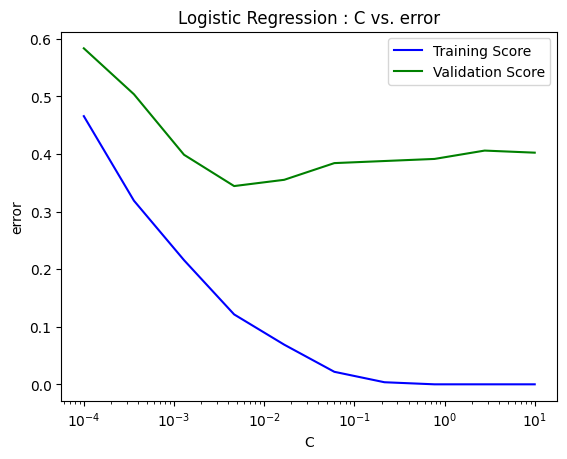


• Logistic Regression{'C': 0.0021544346900318843}
train score:  0.8260869565217391 
test score: 0.575


In [108]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', solver='liblinear')
lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)

# PLot error curves to get insight into the optimal parameter / overfitting
plot_error_curves(parameters = np.logspace(-4, 1, 10), 
                  param_name = 'C',
                  base_estimator = LogisticRegression(multi_class='ovr', solver='liblinear'),
                model_name = "Logistic Regression", 
                log_scale = True)

# Tune the parameters
param_grid = {"C": np.logspace(-3,0,10)}
tuned_lr = parameter_tuning("Logistic Regression", param_grid, LogisticRegression(multi_class='ovr', solver='liblinear'))

---
# MODEL SUMMARIES

| Model      | Testing Score |
| ----------- | ----------- |
| Clustering (K-Means)      | -- |
| Decision trees   | 0.5125        |
| Random Forests  | 0.6875        |
| SVMs (OvO)  | 0.65      |
| Multi class Logistic Regression (OvR)  | 0.575     |

2. **Decision Trees, Random Forests**:
Both of these models were useful for both interpretation and prediction with Random Forests being one the best models with a testing score of 0.6875.

3. **Support Vector Machines (OVO)**:
This model also performed relatively well with a test score of 0.65. This could be because SVM's are mostly assumption free and have pretty stable results. 

4. **Multiclass Logistic Regression (OVR)**:
This model had the third best performance with a test score of 0.575. This could be because the regularization helps handle the high dimension of the data. Additionally, logistic regression doesn't assume a distribution of X which could've been another reason why it worked so well. 

